In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100%!important;}</style>"))

from IPython.display import Image

2018-12-10, BUY EXECUTED, 1.16
2018-10-15, SELL EXECUTED, 1.16
2018-10-16, BUY EXECUTED, 1.16
2018-10-17, SELL EXECUTED, 1.15
2018-10-22, BUY EXECUTED, 1.15
2018-10-23, SELL EXECUTED, 1.15
2018-10-29, BUY EXECUTED, 1.14
2018-10-30, SELL EXECUTED, 1.14
2018-11-14, BUY EXECUTED, 1.13
2018-11-21, SELL EXECUTED, 1.14
2018-11-23, BUY EXECUTED, 1.14
2018-11-23, SELL EXECUTED, 1.13
2018-11-29, BUY EXECUTED, 1.14
2018-10-12, SELL EXECUTED, 1.14
2018-11-12, BUY EXECUTED, 1.14
2018-11-12, SELL EXECUTED, 1.13
2018-12-13, BUY EXECUTED, 1.13
2018-12-14, SELL EXECUTED, 1.13
2018-12-18, BUY EXECUTED, 1.14
2018-12-24, SELL EXECUTED, 1.14
2018-12-26, BUY EXECUTED, 1.14
2018-12-26, SELL EXECUTED, 1.14
2018-12-28, BUY EXECUTED, 1.15
2019-02-01, SELL EXECUTED, 1.13
2019-07-01, BUY EXECUTED, 1.14
2018-12-10, BUY EXECUTED, 1.16
2018-10-15, SELL EXECUTED, 1.16
2018-10-16, BUY EXECUTED, 1.16
2018-10-17, SELL EXECUTED, 1.15
2018-10-22, BUY EXECUTED, 1.15
2018-10-23, SELL EXECUTED, 1.15
2018-10-29, BUY EXECUTED

Start date,2018-10-09
End date,2019-10-01
Total months,1
,Backtest
Annual return,-0.2%
Cumulative returns,-0.0%
Annual volatility,0.0%
Sharpe ratio,-6.42
Calmar ratio,-8.11
Stability,0.71
Max drawdown,-0.0%


C:\Users\Realm\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.03,2018-12-09,2019-08-01,NaT,NaN
1,0.00,2018-10-09,2018-10-09,2018-10-09,1
2,0.00,2018-10-09,2018-10-09,2018-10-09,1
3,0.00,2018-10-09,2018-10-09,2018-10-09,1
4,0.00,2018-10-09,2018-10-09,2018-10-09,1


C:\Users\Realm\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Stress Events,mean,min,max
New Normal,-0.00%,-0.01%,0.00%


Top 10 long positions of all time,max
Data0,0.01%


Top 10 short positions of all time,max


Top 10 positions of all time,max
Data0,0.01%


OverflowError: cannot convert float infinity to integer

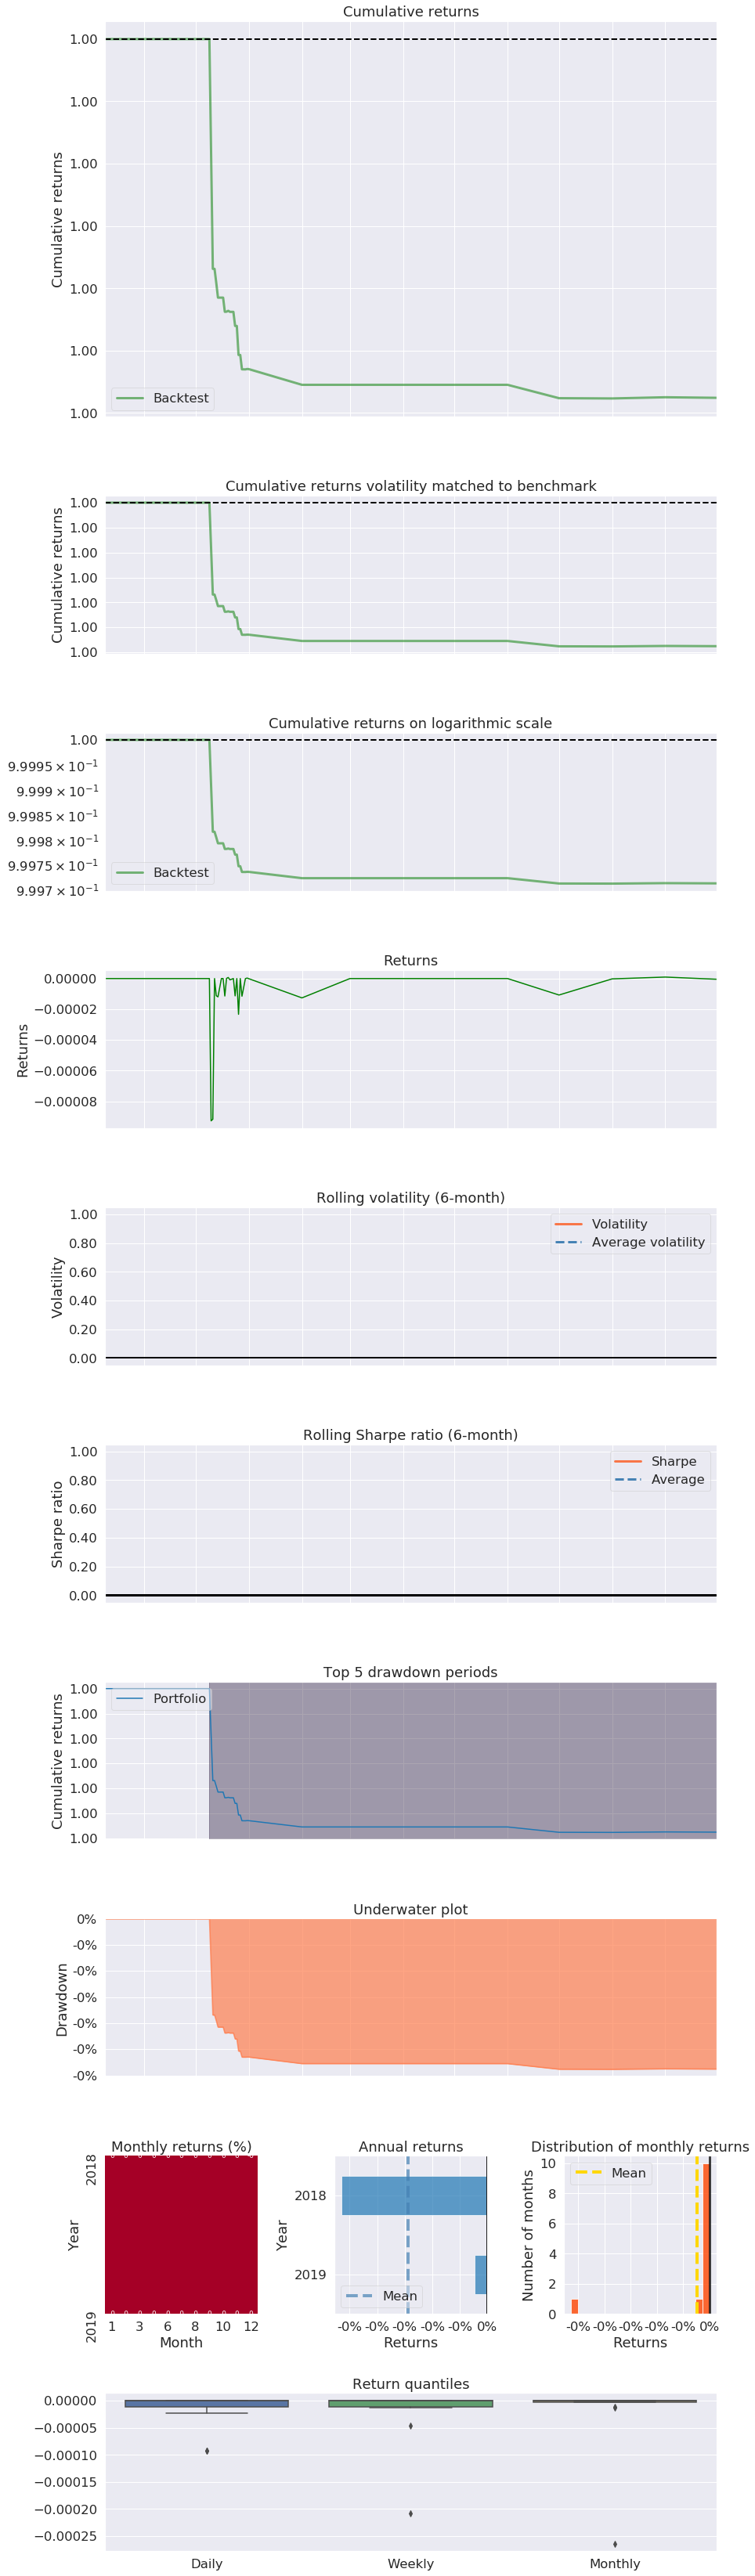

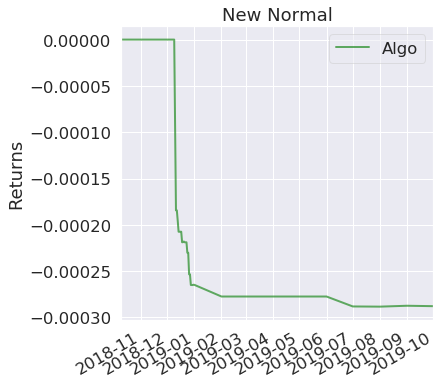

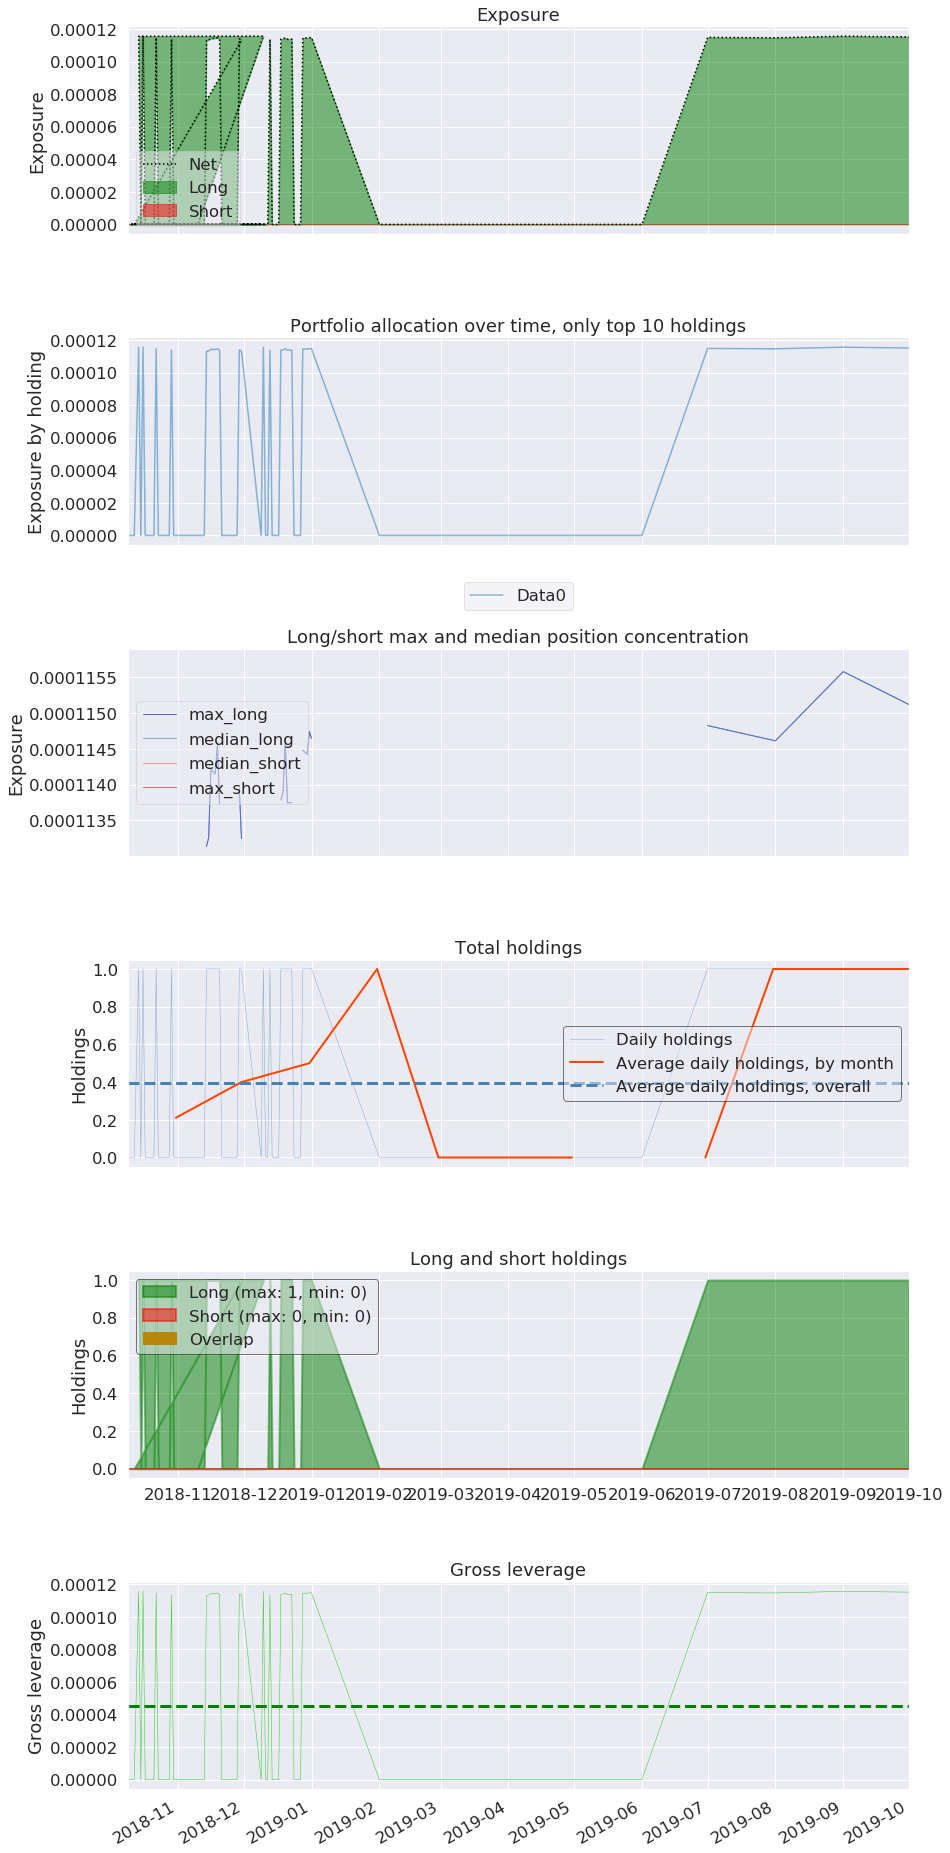

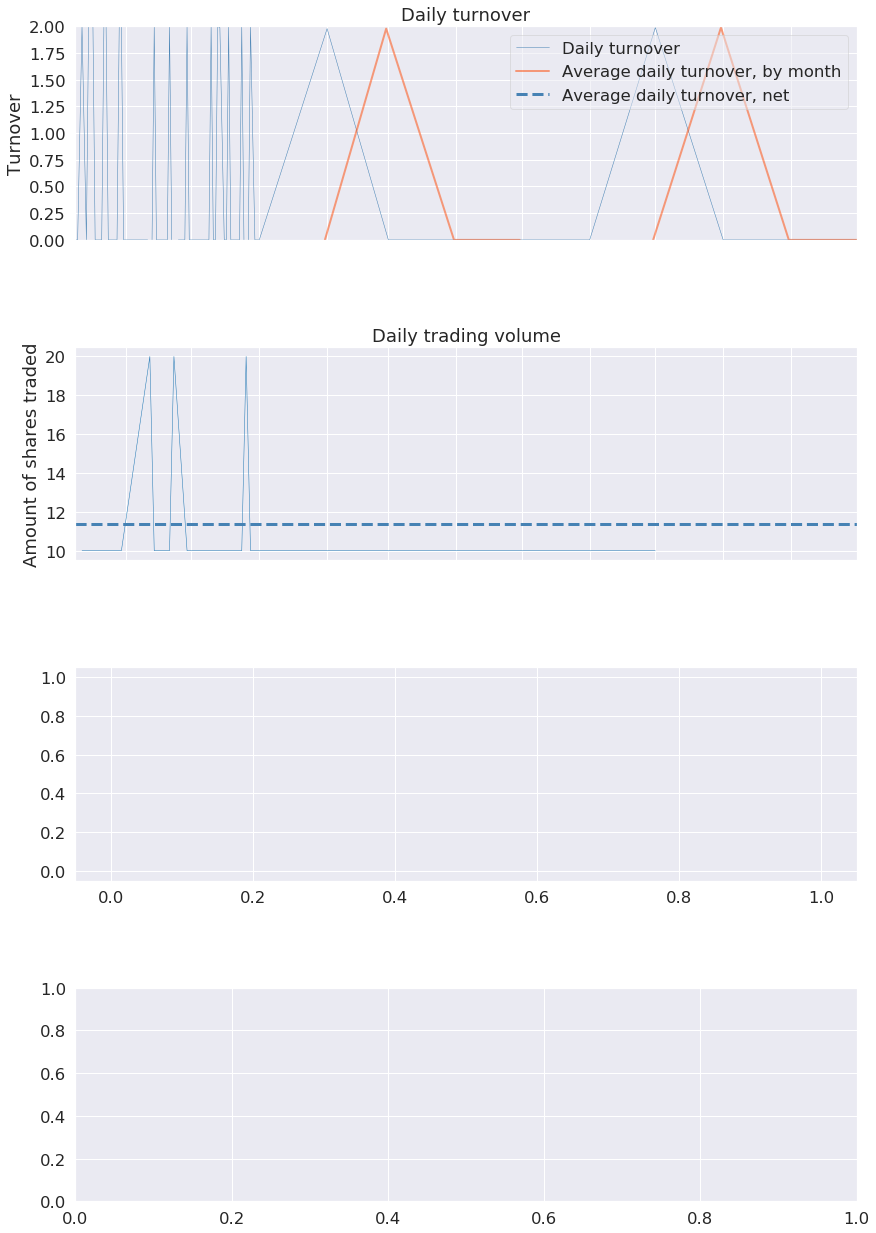

In [7]:
import backtrader as bt
import pandas as pd
import backtrader.indicators as btind
import talib
import pyfolio as pf
from datetime import datetime
%matplotlib inline


class MyStrategy(bt.Strategy):
    
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
        
    params = (('fastperiod', 35),
              ('midperiod' , 75),
             )
    
    def __init__(self):
    
        self.dataclose = self.datas[0].close
        self.order = None
        self.fsma = bt.talib.SMA(self.data, timeperiod=self.p.fastperiod)
        self.msma = bt.talib.SMA(self.data, timeperiod=self.p.midperiod)
      
        self.buysig = bt.ind.CrossOver(self.fsma, self.msma)

    def notify(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enougth cash
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        # Write down: no pending order
        self.order = None
        

    def next(self):
         if not self.position:
            if self.buysig > 0:
                 self.buy()

         elif self.buysig < 0:
             self.close() 
            
        
startcash = 100000
cerebro = bt.Cerebro()
cerebro.addstrategy(MyStrategy)

data = pd.read_csv('D:\DataSource\EURUSD_Candlestick_1_Hour_ASK_01.09.2018-19.10.2019_b.csv',index_col=0,parse_dates=True)

data = bt.feeds.PandasData(dataname=data, fromdate = datetime(2018, 10, 1), todate = datetime(2019, 10, 31))

cerebro.adddata(data)

cerebro.broker.setcash(startcash)
cerebro.addsizer(bt.sizers.FixedSize, stake=10)
cerebro.broker.setcommission(commission=0.1)

cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name = 'SharpeRatio')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name = 'DW')
cerebro.addanalyzer(bt.analyzers.Returns, _name = 'Returns')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name = 'TradeAnalyzer')
cerebro.addanalyzer(bt.analyzers.PyFolio)

portvalue = cerebro.broker.getvalue()
pnl = portvalue - startcash

cerebro.run()

results = cerebro.run()
start = results[0]
pyfoliozer  = start.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

print('SR:', start.analyzers.SharpeRatio.get_analysis())
print('DW:', start.analyzers.DW.get_analysis())
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
print('Returns:', start.analyzers.Returns.get_analysis())
print('P/L: ${}'.format(pnl))

pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    )

cerebro.plot(style='candlestick')

2019-04-01, BUY EXECUTED, 1.14
2019-11-01, SELL EXECUTED, 1.15
2019-11-01, SELL EXECUTED, 1.15
2019-01-23, BUY EXECUTED, 1.14
2019-01-23, BUY EXECUTED, 1.14
2019-01-24, SELL EXECUTED, 1.13
2019-01-24, SELL EXECUTED, 1.13
2019-01-27, BUY EXECUTED, 1.14
2019-01-27, BUY EXECUTED, 1.14
2019-01-02, SELL EXECUTED, 1.14
2019-01-02, SELL EXECUTED, 1.14
2019-02-13, BUY EXECUTED, 1.13
2019-02-13, BUY EXECUTED, 1.13
2019-02-14, SELL EXECUTED, 1.13
2019-02-14, SELL EXECUTED, 1.13
2019-02-18, BUY EXECUTED, 1.13
2019-02-18, BUY EXECUTED, 1.13
2019-02-21, SELL EXECUTED, 1.13
2019-02-21, SELL EXECUTED, 1.13
2019-02-25, BUY EXECUTED, 1.13
2019-02-25, BUY EXECUTED, 1.13
2019-01-03, SELL EXECUTED, 1.14
2019-01-03, SELL EXECUTED, 1.14
2019-11-03, BUY EXECUTED, 1.12
2019-11-03, BUY EXECUTED, 1.12
2019-03-15, SELL EXECUTED, 1.13
2019-03-15, SELL EXECUTED, 1.13
2019-03-15, BUY EXECUTED, 1.13
2019-03-15, BUY EXECUTED, 1.13
2019-03-22, SELL EXECUTED, 1.14
2019-03-22, SELL EXECUTED, 1.14
2019-03-26, BUY EXECUTE

<IPython.core.display.Javascript object>


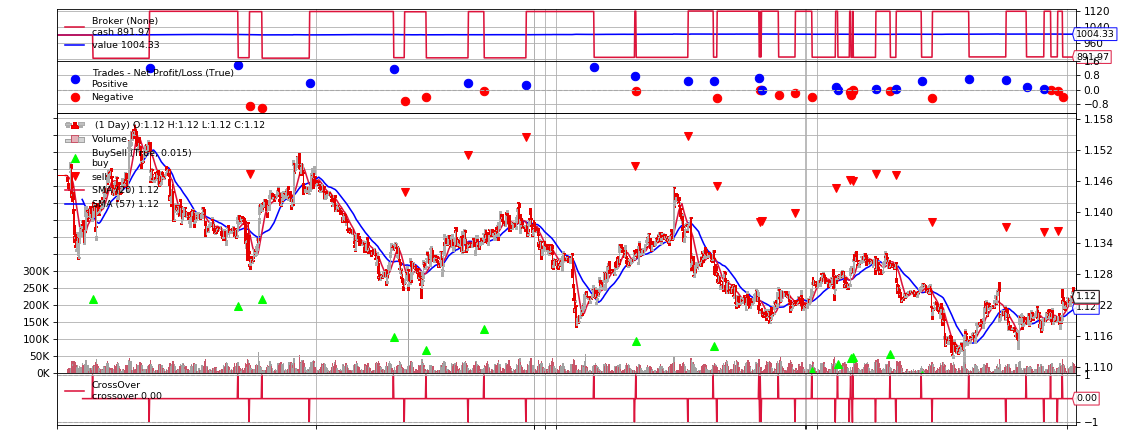

[[<Figure size 432x288 with 5 Axes>]]

In [2]:
##### SMA CROSSOVER 2 #####
import backtrader as bt
import pandas as pd
import backtrader.indicators as btind
import talib
from datetime import datetime
%matplotlib inline

class SmaCross(bt.Strategy):
    # list of parameters which are configurable for the strategy
    
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
        
    params = (('fastperiod', 20),
              ('midperiod' , 57),
             )


    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.fastperiod)  
        sma2 = bt.ind.SMA(period=self.p.midperiod)  
        self.crossover = bt.ind.CrossOver(sma1, sma2)

    def next(self):
        if self.crossover > 0:  # if fast crosses slow to the upside
                self.buy()  # enter long

        elif self.crossover < 0:  # in the market & cross to the downside
            self.close()  # close long position

            
        if self.crossover < 0:  # if fast crosses slow to the upside
                self.sell()  # enter short

        elif self.crossover > 0:  # in the market & cross to the downside
            self.close()  # close short position
            
    def notify(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enougth cash
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        # Write down: no pending order
        self.order = None
                             
        
startcash = 1000
cerebro = bt.Cerebro()
cerebro.addstrategy(SmaCross)
data = pd.read_csv('D:\DataSource\EURUSD_Candlestick_1_Hour_ASK_01.09.2018-19.10.2019_b.csv',index_col=0,parse_dates=True)
#data['openinterest'] = 0
data = bt.feeds.PandasData(dataname=data, fromdate = datetime(2019, 1, 1), todate = datetime(2019, 12, 5))

cerebro.adddata(data)

cerebro.broker.setcash(startcash)
cerebro.addsizer(bt.sizers.FixedSize, stake=100)
# cerebro.broker.setcommission(commission=0.1)

cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name = 'SharpeRatio')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name = 'DW')
cerebro.addanalyzer(bt.analyzers.Returns, _name = 'Returns')

portvalue = cerebro.broker.getvalue()
pnl = portvalue - startcash

cerebro.run()

results = cerebro.run()
start = results[0]

print('SR:', start.analyzers.SharpeRatio.get_analysis())
print('DW:', start.analyzers.DW.get_analysis())
print('Final Portfolio Value: ${}'.format(portvalue))
print('Returns:', start.analyzers.Returns.get_analysis())
print('P/L: ${}'.format(pnl))

cerebro.plot(style='candlestick')

Starting Portfolio Value: 1337.00
Ending Portfolio Value: 1901.69


<IPython.core.display.Javascript object>


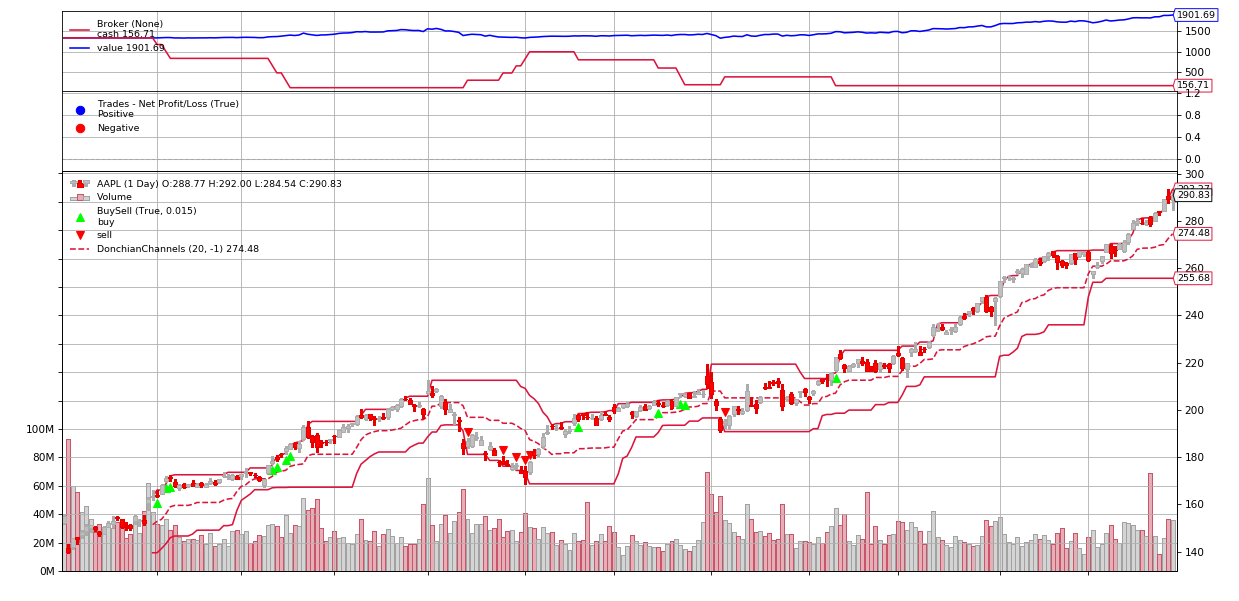

[[<Figure size 432x288 with 4 Axes>]]

In [6]:
##### DonchianChannel #####

from datetime import datetime
import backtrader as bt
%matplotlib inline

class DonchianChannels(bt.Indicator):

    alias = ('DCH', 'DonchianChannel',)

    lines = ('dcm', 'dch', 'dcl',)  # dc middle, dc high, dc low
    params = dict(
        period=20,
        lookback=-1,  # consider current bar or not
    )

    plotinfo = dict(subplot=False)  # plot along with data
    plotlines = dict(
        dcm=dict(ls='--'),  # dashed line
        dch=dict(_samecolor=True),  # use same color as prev line (dcm)
        dcl=dict(_samecolor=True),  # use same color as prev line (dch)
    )

    def __init__(self):
        hi, lo = self.data.high, self.data.low
        if self.p.lookback:  # move backwards as needed
            hi, lo = hi(self.p.lookback), lo(self.p.lookback)

        self.l.dch = bt.ind.Highest(hi, period=self.p.period)
        self.l.dcl = bt.ind.Lowest(lo, period=self.p.period)
        self.l.dcm = (self.l.dch + self.l.dcl) / 2.0  # avg of the above

    def notify(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enougth cash
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        # Write down: no pending order
        self.order = None
        

class MyStrategy(bt.Strategy):
    def __init__(self):
        self.myind = DonchianChannels()

    def next(self):
        if self.data[0] > self.myind.dch[0]:
            self.buy()
        elif self.data[0] < self.myind.dcl[0]:
            self.sell()

data = bt.feeds.YahooFinanceData(dataname='AAPL',
                                  fromdate=datetime(2019, 1, 1),
                                  todate=datetime(2019, 12, 31))            



if __name__ == '__main__':
    cerebro = bt.Cerebro()
    cerebro.addstrategy(MyStrategy)
    cerebro.broker.setcash(1337.0)
    cerebro.broker.setcommission(commission=0.001)

   
    
    cerebro.adddata(data)
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.plot()